In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import nltk
import gensim.downloader
import re
from calendar import month_name, month_abbr
from collections import Counter

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from pprint import pprint

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
stopwords = nltk.corpus.stopwords.words('english')

NUMERIC = '~NUMERIC~'
DATE = '~DATE~'
URL = '~URL~'
PADCHAR = '~PADCHAR~'
UNKNOWN = '~UNKNOWN~'

month_names='|'.join(month_name[i] for i in range(1,13))
month_abbrs='|'.join(month_abbr[i] for i in range(1,13))
date_regex='('+month_names+'|'+month_abbrs+')\s[0-9]{1,2}(st|nd|rd|th)?(,\s[0-9]{4})?'
url_regex = '(www\.|http://|https://)\S+|\S+\.(co|org|net|info|be|gov|edu|html|jpg|jpeg|png|gif)'

PERCENT_VAL = 0.1
TEST_SIZE = 1000

In [2]:
%%time
EMBED_SIZE = 300
google300 = gensim.downloader.load('word2vec-google-news-300')
S = Counter()
C = Counter()
for word in google300.vocab:
    lower = word.lower()
    if lower in stopwords: continue
    S[lower] += google300[word]
    C[lower] += 1
google300 = {w: s / c for w, s, c in zip(S.keys(), S.values(), C.values())}

CPU times: user 1min 6s, sys: 4.13 s, total: 1min 10s
Wall time: 1min 22s


In [3]:
news = pd.read_csv('fake-news/train.csv')
news = news.dropna()
news = news[['title','text','label']]
news = news.sample(frac=1, random_state=RANDOM_SEED)

In [4]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(news.label)
y_te = y[:TEST_SIZE]
y = y[TEST_SIZE:]

trval = news.iloc[TEST_SIZE:]
trval = trval.copy(deep=True)
te = news.iloc[:TEST_SIZE]
te = te.copy(deep=True)

tr_size = int((1 - PERCENT_VAL) * len(trval))
tr = trval.iloc[:tr_size]
val = trval.iloc[tr_size:]

print(len(tr[tr.label==0]), len(tr[tr.label==1]))
print(len(val[val.label==0]), len(val[val.label==1]))
print(len(te[te.label==0]), len(te[te.label==1]))

8820 6736
990 739
551 449


In [5]:
%%time
def split_by_case(s):
    if (not s[1:].isupper()) and (not s[1:].islower()):
        for i in range(1,len(s)-1):
            if s[i-1].islower() and s[i].isupper():
                return [s[:i]] + split_by_case(s[i:])
            elif s[i].islower() and s[i+1].isupper():
                return [s[:i+1]] + split_by_case(s[i+1:])
    return [s]

def supertokenize(txt):
    txt = re.sub(date_regex, DATE, re.sub(url_regex, URL, txt))
    tokens = nltk.word_tokenize(txt)
    y = []
    for t in tokens:
        if t in '!"\'(),--./:;<?[\\]{|}“”‘’—': continue
        t = t.lower()
        if t != "n't": t = re.sub('["\']','',t)
        if t in stopwords: continue
        if t == URL:
            y.append(URL)
            continue
        if (re.sub('^[0-9]+(/[0-9]+)+$','',t) == '') or (t == DATE):
            y.append(DATE)
            continue
        if t.isnumeric() or\
        (t[:-2].isnumeric() and (t[-2:].lower() in ['st','nd'])):
            y.append(NUMERIC)
            continue
        if t in google300:
            y.append(t)
        else:
            if t.replace('.', '') in google300:
                y.append(t.replace('.', ''))
                continue
            is_found = False
            for x in split_by_case(re.sub('[^A-Za-z]','',t)):
                if x in google300:
                    y.append(x)
                    is_found = True
            if is_found: continue
            for st in re.split('-',re.sub('[^A-Za-z0-9\.~]','-',t)):
                for x in [st, st[:-1], st[1:], st.replace('s','z'),
                          st.replace('ou','o'), st.replace('re','er')]:
                    if x in google300:
                        y.append(x)
                        is_found = True
                        break
            if not is_found: y.append(UNKNOWN)
    return y

def supertokenizeplus(x, lab):
    global wc_all, wc_fake, wc_real
    
    y = supertokenize(x)
    
    wc_all += Counter(y)
    
    c = Counter()
    for a in y: c[a] = 1
    if lab == 1:
        wc_fake += c
    else:
        wc_real += c
    
    return y

wc_all=Counter()
wc_fake=Counter()
wc_real=Counter()
trval['tokenized_title'] = trval.apply(lambda x: supertokenizeplus(x.title,x.label),axis=1)
trval['tokenized_text'] = trval.apply(lambda x: supertokenizeplus(x.text,x.label),axis=1)

CPU times: user 11min 18s, sys: 661 ms, total: 11min 18s
Wall time: 11min 19s


In [6]:
term_freq = Counter()
total_wc_all = np.sum(list(wc_all.values()))
for k in wc_all:
    term_freq[k] = np.abs(wc_real[k] - wc_fake[k]) /\
                  np.sqrt(wc_real[k] + wc_fake[k]) + wc_all[k] / total_wc_all
thresh = term_freq.most_common(25000)[-1][1]
tokens = [k for k, v in term_freq.items() if v >= thresh]

vocab, i = {PADCHAR: 0, DATE: 1, URL: 2, NUMERIC: 3, UNKNOWN: 4}, 5
for w in tokens:
    if w in (PADCHAR, DATE, URL, NUMERIC, UNKNOWN): continue
    vocab[w] = i
    i += 1
id2word = {v:k for k,v in vocab.items()}

i, term_freq.most_common(10)

(25002,
 [('york', 78.47394695146568),
  ('times', 71.15367360741507),
  ('new', 68.66280945930444),
  ('mr.', 59.96479589870816),
  ('breitbart', 59.26412908810515),
  ('said', 47.811481733299686),
  ('s.', 45.210467836523684),
  ('ms.', 44.68743932582065),
  ('u.', 44.44265930162377),
  ('a.', 39.3531969916947)])

In [7]:
%%time
te['tokenized_title'] = te.apply(lambda x: supertokenize(x.title),axis=1)
te['tokenized_text'] = te.apply(lambda x: supertokenize(x.text),axis=1)

CPU times: user 23.3 s, sys: 40 ms, total: 23.3 s
Wall time: 23.3 s


In [8]:
def clean(text,length):
    f = [vocab[w] if w in vocab else vocab[UNKNOWN] for w in text]
    f = f[:length]
    return (length - len(f)) * [vocab[PADCHAR]] + f
trval['text_as_ints'] = trval.tokenized_text.apply(clean,args=[512])
trval['title_as_ints'] = trval.tokenized_text.apply(clean,args=[64])
te['text_as_ints'] = te.tokenized_text.apply(clean,args=[512])
te['title_as_ints'] = te.tokenized_text.apply(clean,args=[64])

X = [np.array(trval.text_as_ints.to_list()), np.array(trval.title_as_ints.to_list())]
X_te = [np.array(te.text_as_ints.to_list()), np.array(te.title_as_ints.to_list())]

In [9]:
input_text = tf.keras.layers.Input(shape=[None])
input_title = tf.keras.layers.Input(shape=[None])
mask = tf.keras.layers.Lambda(lambda inputs: tf.keras.backend.not_equal(inputs, 0))
def emb():
    e = np.zeros((len(vocab),EMBED_SIZE))
    v = np.random.uniform(-1,1,EMBED_SIZE)
    for i in range(len(vocab)):
        try:
            g = google300[id2word[i]]
            e[i] = g + v * np.linalg.norm(g) / np.linalg.norm(v)
        except KeyError:
            assert i < 5, i
            if i in [1, 2, 3]: # leave unknown and padding zero
                e[i] = v / np.linalg.norm(v)
    return tf.keras.layers.Embedding(input_dim=e.shape[0],
                                     output_dim=e.shape[1],
                                     weights=[e],
                                     trainable=False)
emb_text = emb()(input_text)
emb_title = emb()(input_title)
l1l2 = tf.keras.regularizers.L1L2(l1=1e-6,l2=2e-6)
def gru(units):
    return tf.keras.layers.GRU(units, dropout=0.2, recurrent_dropout=0.2,
                               kernel_regularizer=l1l2)
gru_text = tf.keras.layers.Bidirectional(gru(50))(emb_text,mask=mask(input_text))
gru_title = gru(50)(emb_title,mask=mask(input_title))
concat = tf.keras.layers.Concatenate()([gru_text, gru_title])
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
model = tf.keras.Model(inputs=[input_text, input_title], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7500600     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X, y, epochs=1, batch_size=64)

271/271 [==============================] - 436s 2s/step - loss: 0.4878 - accuracy: 0.7496


In [11]:
for i in range(len(model.layers)):
    model.layers[i].trainable = False
    if i in [2, 4]:
        model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7500600     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X, y, epochs=1, batch_size=64)

271/271 [==============================] - 402s 1s/step - loss: 0.1627 - accuracy: 0.9404


In [13]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7500600     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [14]:
from sklearn.utils import class_weight
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics='accuracy')
checkpoint_filepath = '/tmp/checkpoint_v0'
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1],
                                                  y=[w for x in y for w in x])
class_weights = {i: weight for i, weight in enumerate(class_weights)}
model.fit(
    X, y, validation_split=PERCENT_VAL, epochs=10, batch_size=32,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )], class_weight=class_weights
)

Epoch 1/10
487/487 [==============================] - 701s 1s/step - loss: 0.0596 - accuracy: 0.9848 - val_loss: 0.0486 - val_accuracy: 0.9884
Epoch 2/10
487/487 [==============================] - 683s 1s/step - loss: 0.0172 - accuracy: 0.9987 - val_loss: 0.0500 - val_accuracy: 0.9861
Epoch 3/10
487/487 [==============================] - 682s 1s/step - loss: 0.0250 - accuracy: 0.9967 - val_loss: 0.0456 - val_accuracy: 0.9884
Epoch 4/10
487/487 [==============================] - 2319s 5s/step - loss: 0.0103 - accuracy: 0.9997 - val_loss: 0.0482 - val_accuracy: 0.9867
Epoch 5/10
487/487 [==============================] - 693s 1s/step - loss: 0.0092 - accuracy: 0.9999 - val_loss: 0.0475 - val_accuracy: 0.9867
Epoch 6/10
487/487 [==============================] - 673s 1s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0452 - val_accuracy: 0.9884
Epoch 7/10
487/487 [==============================] - 674s 1s/step - loss: 0.0076 - accuracy: 0.9998 - val_loss: 0.1208 - val_accuracy: 0.956

In [15]:
model.load_weights(checkpoint_filepath)
y_hat = model.predict(X_te)
most_off = np.argmax(np.abs(y_hat-y_te))
te.iloc[most_off].title, te.iloc[most_off].text, y_te[most_off], y_hat[most_off]

('Trump’s National Security Adviser: “Islam is a Political Ideology… Hides behind this Notion of it being a Religion”!',
 'by Onan Coca, Freedom OutPost : \nIn a speech from August that is now making waves across the country, president-elect Donald Trump’s National Security Adviser designate, Lt. General Michael Flynn (retired) told the Dallas chapter of ACT! For America that “Islam is a political ideology, it is a political ideology. It definitely hides behind this notion of it being a religion.” \nThe comments are sure to be brought back up when Flynn goes before the Senate to testify during his confirmation hearings. However, Flynn’s personality and his public persona lead me to believe that he’s not worried about facing tough questions from hostile Democrat Senators. \nIn his speech, Flynn further commented on the differences between Christianity and Islam before making some even more controversial comments about world Islam today. \n“Islam is a political ideology, it is a politica

In [16]:
model.evaluate(X_te, y_te)

32/32 [==============================] - 3s 91ms/step - loss: 0.0720 - accuracy: 0.9750


[0.07201295346021652, 0.9750000238418579]

In [17]:
def get_reshaped_weights(model,layer_id):
    W=np.array(model.layers[layer_id].get_weights())
    W=W.reshape(W.shape[1],W.shape[2])
    return W
text_embed = get_reshaped_weights(model,2)
title_embed = get_reshaped_weights(model,4)

<ipython-input-18-92e1c33b0327>:8: RuntimeWarning: invalid value encountered in true_divide
  cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
<ipython-input-18-92e1c33b0327>:4: RuntimeWarning: invalid value encountered in greater_equal
  n_ = np.sum(arr >= thresh)


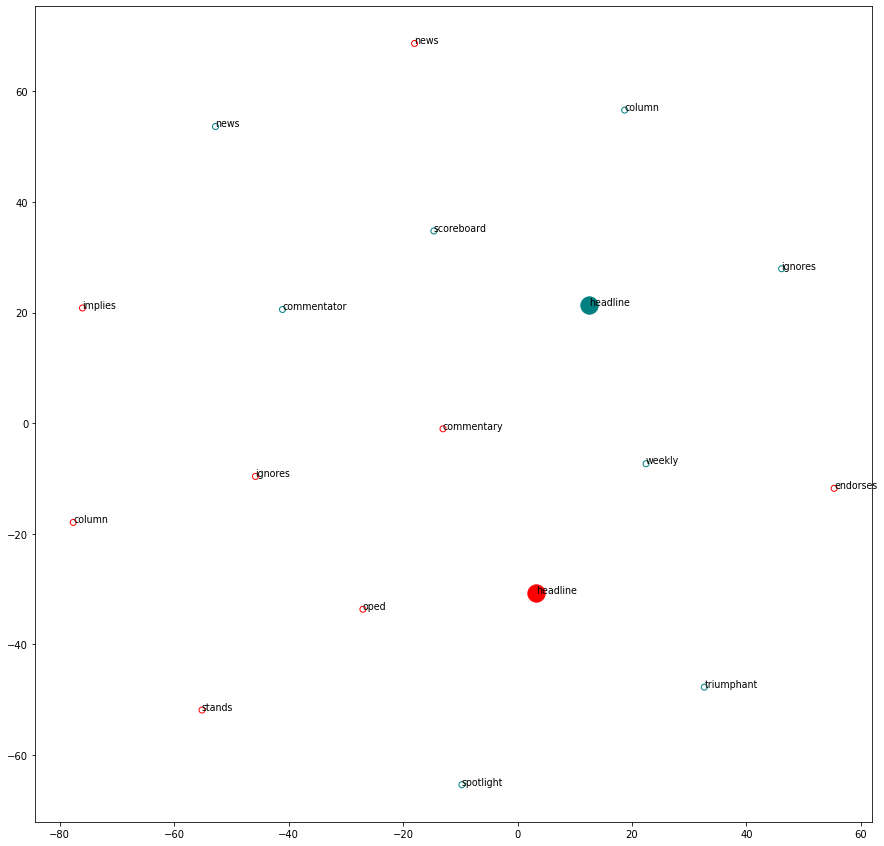

In [18]:
def get_top_n_plus_ties(arr, n):
    sorted_args = np.argsort(-arr)
    thresh = arr[sorted_args[n]]
    n_ = np.sum(arr >= thresh)
    return sorted_args[:n_]
def get_most_similar(word, W, n):
    b = W[vocab[word]]
    cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
    return get_top_n_plus_ties(cs, n)
def create_words_plot(embed1, embed2, WORD, k=9):
    ids1 = get_most_similar(WORD, embed1, k-1)
    ids2 = get_most_similar(WORD, embed2, k-1)
    words1 = [id2word[i] for i in ids1]
    words2 = [id2word[i] for i in ids2]
    v = TSNE(n_components=2,random_state=RANDOM_SEED).fit_transform(
        np.concatenate([embed1[ids1],embed2[ids2]]))
    fig = plt.figure(figsize=(15,15))
    plt.scatter(v[:k,0],v[:k,1],facecolors='none',edgecolors='teal')
    plt.scatter(v[k:,0],v[k:,1],facecolors='none',edgecolors='red')
    for i, word in enumerate(words1):
        plt.annotate(word,(v[i,0],v[i,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i,0],v[i,1],c='teal',s=300)
    for i, word in enumerate(words2):
        plt.annotate(word,(v[i+k,0],v[i+k,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i+k,0],v[i+k,1],c='red',s=300)
create_words_plot(text_embed,title_embed,'headline')